In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from PIL import Image
import inktime as ikt
import cv2

In [189]:
def extract_roi(image, x, y, w, h, line, dark = False):
    #Input: np array of image (bands, pixels, frames)
    # (x,y)= (frames,pixels) top left coordinate of ROI
    # width (w) and height (h) of ROI
    
    #Output: ROI and a bounding box used for imaging the ROI within the original image
    
    roi =  image[y:y+h, x:x+w]
    box = np.copy(image)
    if dark == False:
        intensity = 0
    if dark == True:
        intensity = np.max(image)
    
    box[y:y+line, x:x+w+line] = intensity # top line
    box[y:y+h+line, x:x+line] = intensity # left line
    box[y+h:y+h+line, x:x+w+line] = intensity # bottom line
    box[y:y+h+line, x+w:x+w+line] = intensity # right line
    
    return roi, box

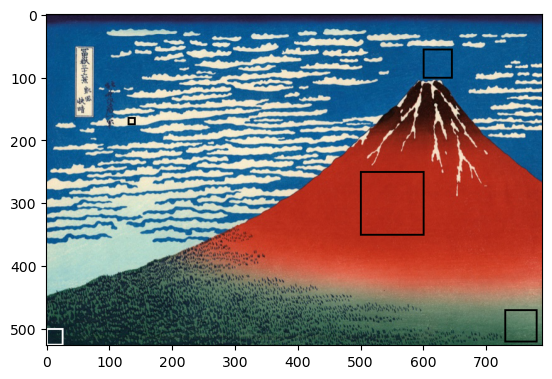

In [191]:
# Load in Red Fuji
img = Image.open("red_fuji.jpg") # Shape (x,y,RGB)
img = np.array(img)

red, box =  extract_roi(img, 500, 250, 100,100, 3)
prussian, box =  extract_roi(box, 600, 55, 45,45, 3)
green, box = extract_roi(box, 730, 470, 50,50, 3)
indigo, box = extract_roi(box, 0, 500, 25,25, 3, dark = True)
white, box = extract_roi(box, 130, 164, 10,10, 3)

colors         =  [white, red, prussian, green, indigo] # main colors in the red fuji
colors_meanRGB =  [] # mean RGB values of those colors

# Calculate mean RGB (mean over spatial dimensions)
for color in colors:
    colors_meanRGB.append(np.mean(color, axis=(0, 1)))

plt.imshow(box)
plt.show()

[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


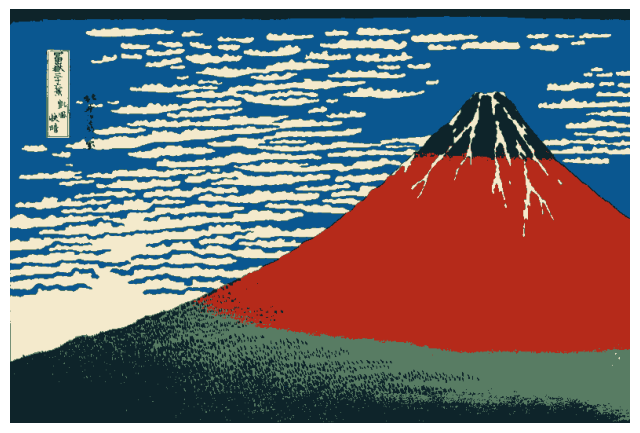

In [215]:
K = 5  # Number of main colors

#transform image to color vectors
pixels = img.reshape(-1, 3).astype(np.float32) #from (x,y,3) to (x*y, 3)/ [R,G,B] per pixel


# Stops k_means if:
# cluster centers move less than epsilon (0.2)
# stop after fixed number of iterations (50)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.2)

# K_means: clusters the pixels based on color

# runs 10 times with differen intializations (attempts)
# Randomly initialize (None, flags)
# Centers =  RGB values clusters centers
# Labels =  cluster index
compactness, labels, centers = cv2.kmeans(pixels, K, None, criteria, attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS)

#Labels per pixel
labels_img = labels.reshape(img.shape[:2])

# Match cluster centers to reference colors
distances = cdist(centers, colors_meanRGB)
cluster_to_color = np.argmin(distances, axis=1)

# Refill with averages
out = np.zeros_like(img, dtype=np.float32)

for cluster_idx in range(K):
    out[labels_img == cluster_idx] = colors_meanRGB[
        cluster_to_color[cluster_idx]
    ]

out = out.astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(out)
plt.axis("off")
plt.show()
